## Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
import os
from keras import layers
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import random
# from imgaug import augmenters as iaa
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Subtract, Conv2DTranspose, concatenate, Cropping2D
import tensorflow as tf
import cv2

## Load Dataset

Here, we are using numpy as Keras is used with numpy

In [2]:
## Load Dataset
def load_dataset():
    datasets = ['real', 'easy', 'medium', 'hard']
    data_dict = {}
    for dataset in datasets:
        x_data = np.load(f'dataset/x_{dataset}.npy')
        y_data = np.load(f'dataset/y_{dataset}.npy')
        data_dict[dataset] = (x_data, y_data)
        print(f"{dataset}: X shape {x_data.shape}, Y shape {y_data.shape}")

    return data_dict

data_dict = load_dataset()

real: X shape (6000, 90, 90), Y shape (6000, 4)
easy: X shape (17931, 90, 90), Y shape (17931, 4)
medium: X shape (17067, 90, 90), Y shape (17067, 4)
hard: X shape (14272, 90, 90), Y shape (14272, 4)


In [3]:
def load_segmentation_dataset():
    """
    Load the fingerprint images and their corresponding mask annotations.
    If the dataset doesn't exist, create synthetic masks for demonstration.
    """
    # For demonstration purposes, we'll create synthetic masks
    # In a real scenario, you would load actual annotated masks
    
    print("Loading fingerprint region segmentation dataset...")
    
    # Try to load existing segmentation dataset if available
    try:
        x_images = np.load('dataset/x_segmentation.npy')
        y_masks = np.load('dataset/y_segmentation.npy')
        print(f"Loaded existing segmentation dataset: {x_images.shape}, {y_masks.shape}")
        return x_images, y_masks
    except:
        print("Creating synthetic segmentation dataset...")
    
    # Use the existing fingerprint images
    data_dict = load_dataset()
    
    # Combine images from different difficulty levels
    all_images = np.concatenate([
        data_dict['real'][0],
        data_dict['easy'][0],
        data_dict['medium'][0],
        data_dict['hard'][0]
    ], axis=0)
    
    # Create synthetic masks (in a real scenario, these would be manually annotated)
    masks = []
    for img in all_images:
        # Create a synthetic mask based on pixel intensity
        # This assumes fingerprints are darker than the background
        img_gray = img.squeeze()
        
        # Simple thresholding to create a binary mask
        _, binary = cv2.threshold(img_gray, 200, 255, cv2.THRESH_BINARY_INV)
        
        # Clean up the mask with morphological operations
        kernel = np.ones((5, 5), np.uint8)
        binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        binary = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
        
        # Normalize to 0-1
        mask = binary / 255.0
        masks.append(mask)
    
    # Convert to numpy arrays
    x_images = all_images
    y_masks = np.array(masks)[..., np.newaxis]
    
    # Save the dataset for future use
    os.makedirs('dataset', exist_ok=True)
    np.save('dataset/x_segmentation.npy', x_images)
    np.save('dataset/y_segmentation.npy', y_masks)
    
    print(f"Created segmentation dataset: X shape {x_images.shape}, Y shape {y_masks.shape}")
    return x_images, y_masks

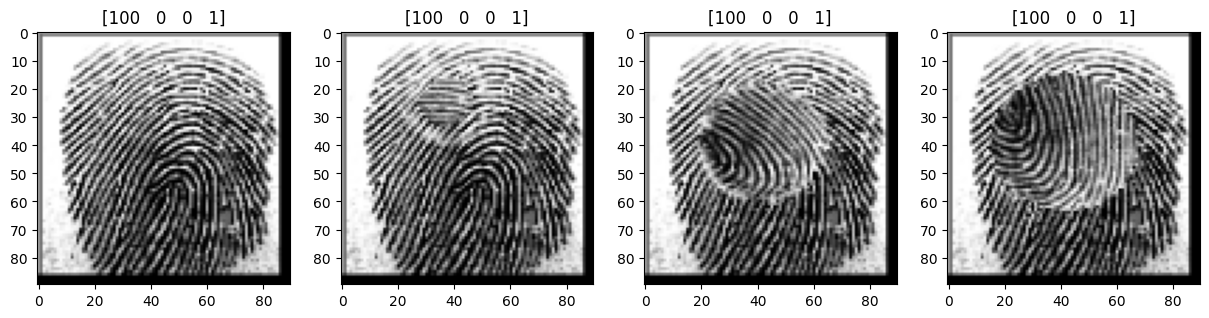

In [4]:
# Visualize a sample from each dataset
def visualize_samples(data_dict):
    plt.figure(figsize=(15, 10))
    for idx, (key, (x, y)) in enumerate(data_dict.items(), start=1):
        plt.subplot(1, 4, idx)
        plt.title(y[0])
        plt.imshow(x[0].squeeze(), cmap='gray')
    plt.show()

visualize_samples(data_dict)

In [5]:
def visualize_masks(images, masks, num_samples=3):
    """
    Visualize sample images and their corresponding segmentation masks.
    """
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5*num_samples))
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 3, i*3+1)
        plt.title('Original Image')
        plt.imshow(images[idx].squeeze(), cmap='gray')
        
        # Mask
        plt.subplot(num_samples, 3, i*3+2)
        plt.title('Segmentation Mask')
        plt.imshow(masks[idx].squeeze(), cmap='gray')
        
        # Overlay
        plt.subplot(num_samples, 3, i*3+3)
        plt.title('Overlay')
        overlay = np.zeros_like(images[idx].squeeze())
        overlay = np.stack([overlay, masks[idx].squeeze()*255, overlay], axis=-1)
        plt.imshow(images[idx].squeeze(), cmap='gray')
        plt.imshow(overlay, alpha=0.5)
    
    plt.tight_layout()
    plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.metrics import Metric

@keras.saving.register_keras_serializable()
class IoU(Metric):
    def __init__(self, name='iou', **kwargs):
        super(IoU, self).__init__(name=name, **kwargs)
        self.intersection = self.add_weight(name='intersection', initializer='zeros')
        self.union = self.add_weight(name='union', initializer='zeros')
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.cast(y_pred > 0.5, tf.float32)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
        
        self.intersection.assign_add(intersection)
        self.union.assign_add(union)
        
    def result(self):
        return self.intersection / (self.union + 1e-6)  # Adding small epsilon to avoid division by zero
        
    def reset_state(self):
        self.intersection.assign(0.0)
        self.union.assign(0.0)

# Train Test Split

In [7]:
x_data = np.concatenate([data_dict['easy'][0], data_dict['medium'][0], data_dict['hard'][0]], axis=0)
label_data = np.concatenate([data_dict['easy'][1], data_dict['medium'][1], data_dict['hard'][1]], axis=0)

# we use 90/10 split
x_train, x_val, label_train, label_val = train_test_split(x_data, label_data, test_size=0.1)
print(f"x_train: {x_train.shape}, label_train: {label_train.shape}")
print(f"x_val: {x_val.shape}, label_val: {label_val.shape}")

x_train: (44343, 90, 90), label_train: (44343, 4)
x_val: (4927, 90, 90), label_val: (4927, 4)


## Preview Augmentation

These are functions and transformations that will serve to transform and distort the original image that we will use for testing the trained model.


In [8]:
def preview_augmentation(images):
    augmented_images = []
    
    for _ in range(9):
        img = images[0].copy()
        
        # Apply Gaussian blur
        blur_strength = random.uniform(0, 0.5)
        if blur_strength > 0:
            blur_size = int(blur_strength * 10) * 2 + 1  # Must be odd number
            img = cv2.GaussianBlur(img, (blur_size, blur_size), blur_strength)
        
        # Apply affine transformations
        h, w = img.shape[:2]
        
        # Random scale
        scale_x = random.uniform(0.9, 1.1)
        scale_y = random.uniform(0.9, 1.1)
        
        # Random translation
        tx = random.uniform(-0.1, 0.1) * w
        ty = random.uniform(-0.1, 0.1) * h
        
        # Random rotation
        angle = random.uniform(-30, 30)
        
        # Compute affine transform matrix
        center = (w // 2, h // 2)
        M = cv2.getRotationMatrix2D(center, angle, 1.0)
        M[0, 0] *= scale_x
        M[1, 1] *= scale_y
        M[0, 2] += tx
        M[1, 2] += ty
        
        # Apply affine transform
        img = cv2.warpAffine(img, M, (w, h), borderMode=cv2.BORDER_CONSTANT, borderValue=255)
        
        augmented_images.append(img)
    
    plt.figure(figsize=(16, 6))
    plt.subplot(2, 5, 1)
    plt.title('Original')
    plt.imshow(images[0].squeeze(), cmap='gray')
    for i, aug in enumerate(augmented_images):
        plt.subplot(2, 5, i + 2)
        plt.title(f'Aug {i + 1}')
        plt.imshow(aug.squeeze(), cmap='gray')
    plt.show()


## Make Label Dictionary Lookup Table

This is used later on, to find the original index of a randomly picked sample from the validation set in order to compare the images for the testing.

In [9]:
label_real_dict = {''.join(y.astype(str)).zfill(6): i for i, y in enumerate(data_dict['real'][1])}

## Data Generator

This is necessary step in image processing using Keras, especially a big dataset that cannot fit into the memory during training. It is a class that produces batches of data that can feed into multiple cores right away.

In [10]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, x, label, x_real, label_real_dict, batch_size=32, shuffle=True):
        self.x = x
        self.label = label
        self.x_real = x_real
        self.label_real_dict = label_real_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()
    
    def __len__(self):
        return len(self.x) // self.batch_size
    
    def __getitem__(self, index):
        x1_batch = self.x[index * self.batch_size:(index + 1) * self.batch_size].copy()
        label_batch = self.label[index * self.batch_size:(index + 1) * self.batch_size]
        
        x2_batch = np.empty((self.batch_size, 90, 90, 1), dtype=np.float32)
        y_batch = np.zeros((self.batch_size, 1), dtype=np.float32)
        
        # Apply augmentations if shuffle is True
        if self.shuffle:
            # Apply OpenCV augmentations as in previous example
            for i in range(len(x1_batch)):
                # Augmentation code as provided earlier
                pass
        
        for i, l in enumerate(label_batch):
            match_key = ''.join(l.astype(str)).zfill(6)
            if random.random() > 0.5:
                x2_batch[i] = self.x_real[self.label_real_dict[match_key]][..., np.newaxis]
                y_batch[i] = 1.
            else:
                while True:
                    unmatch_key, unmatch_idx = random.choice(list(self.label_real_dict.items()))
                    if unmatch_key != match_key:
                        x2_batch[i] = self.x_real[unmatch_idx][..., np.newaxis]
                        break
                y_batch[i] = 0.
        
        # Return data in a format TensorFlow expects
        # Instead of returning [x1_batch, x2_batch], y_batch
        # Create a tuple of inputs
        x_input = (
            x1_batch.astype(np.float32) / 255., 
            x2_batch.astype(np.float32) / 255.
        )
        
        return x_input, y_batch
    
    def on_epoch_end(self):
        if self.shuffle:
            self.x, self.label = shuffle(self.x, self.label)

## Create Model

Here is the concept of the model:
- 2 models with 2x Convolutional and Pooling layers, sharing weights
- The outputs are subtracted, and the subtraction is fed to another Conv + Pooling layer
- Then that is fed to a sigmoid for final classification if the 2 images are same or not

![image.png](attachment:image.png)

In [11]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
from tensorflow.keras.models import Model

def build_unet_model(input_shape=(90, 90, 1)):
    """
    Build a U-Net model for image segmentation with proper shape handling.
    """
    inputs = Input(input_shape)
    
    # Encoder (downsampling path)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3, 3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)  # 90→45
    
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3, 3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)  # 45→22
    
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3, 3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)  # 22→11
    
    # Bridge
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3, 3), activation='relu', padding='same')(c4)
    
    # Decoder (upsampling path)
    u5 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c4)  # 11→22
    u5 = concatenate([u5, c3])  # Both 22×22
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(u5)
    c5 = Conv2D(64, (3, 3), activation='relu', padding='same')(c5)
    
    u6 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c5)  # 22→44
    # Crop c2 to match u6's shape if needed
    diff_y = c2.shape[1] - u6.shape[1]  # 45-44=1
    diff_x = c2.shape[2] - u6.shape[2]  # 45-44=1
    if diff_y > 0 or diff_x > 0:
        from tensorflow.keras.layers import Cropping2D
        c2 = Cropping2D(cropping=((0, diff_y), (0, diff_x)))(c2)
    u6 = concatenate([u6, c2])  # Both 44×44
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(u6)
    c6 = Conv2D(32, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c6)  # 44→88
    # Crop c1 to match u7's shape if needed
    diff_y = c1.shape[1] - u7.shape[1]  # 90-88=2
    diff_x = c1.shape[2] - u7.shape[2]  # 90-88=2
    if diff_y > 0 or diff_x > 0:
        from tensorflow.keras.layers import Cropping2D
        c1 = Cropping2D(cropping=((0, diff_y), (0, diff_x)))(c1)
    u7 = concatenate([u7, c1])  # Both 88×88
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(u7)
    c7 = Conv2D(16, (3, 3), activation='relu', padding='same')(c7)
    
    # Output layer - match original input shape with cropping if needed
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c7)
    if outputs.shape[1] != input_shape[0] or outputs.shape[2] != input_shape[1]:
        from tensorflow.keras.layers import ZeroPadding2D
        outputs = ZeroPadding2D(padding=((1, 1), (1, 1)))(outputs)  # 88→90
    
    model = Model(inputs=[inputs], outputs=[outputs])
    # model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'IoU'])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[IoU(name='IoU')]
    )
    
    return model


In [12]:
def evaluate_segmentation(model, x_val, y_val, num_samples=5):
    """
    Evaluate the segmentation model and visualize results.
    """
    # Predict on validation data
    y_pred = model.predict(x_val)
    
    # Calculate IoU scores
    iou_scores = []
    for i in range(len(y_val)):
        true = y_val[i].squeeze()
        pred = (y_pred[i].squeeze() > 0.5).astype(np.float32)
        
        intersection = np.sum(true * pred)
        union = np.sum(true) + np.sum(pred) - intersection
        iou = intersection / (union + 1e-7)
        iou_scores.append(iou)
    
    mean_iou = np.mean(iou_scores)
    print(f"Mean IoU on validation set: {mean_iou:.4f}")
    
    # Visualize random samples
    indices = np.random.choice(range(len(x_val)), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5*num_samples))
    for i, idx in enumerate(indices):
        # Original image
        plt.subplot(num_samples, 3, i*3+1)
        plt.title('Original Image')
        plt.imshow(x_val[idx].squeeze(), cmap='gray')
        
        # Ground truth mask
        plt.subplot(num_samples, 3, i*3+2)
        plt.title('Ground Truth')
        plt.imshow(y_val[idx].squeeze(), cmap='gray')
        
        # Predicted mask
        plt.subplot(num_samples, 3, i*3+3)
        plt.title(f'Prediction (IoU: {iou_scores[idx]:.4f})')
        plt.imshow(y_pred[idx].squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()
    
    return mean_iou

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

def train_segmentation_model():
    """
    Train a U-Net model for fingerprint region segmentation.
    """
    # Load or create the segmentation dataset
    x_images, y_masks = load_segmentation_dataset()
    
    # Normalize the images
    x_images = x_images.astype(np.float32) / 255.0
    
    # Split into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(
        x_images, y_masks, test_size=0.2, random_state=42
    )
    
    # Visualize some samples
    visualize_masks(x_train, y_train, num_samples=3)
    
    # Create U-Net model
    model = build_unet_model(input_shape=(90, 90, 1))
    model.summary()
    
    early_stopping = EarlyStopping(
        monitor='val_custom_iou',  # Match the metric name
        patience=10,
        restore_best_weights=True,
        mode='max',
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        x_train, y_train,
        batch_size=32,
        epochs=5,
        validation_data=(x_val, y_val),
        callbacks=[early_stopping]
    )
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Evaluate the model on validation data
    evaluate_segmentation(model, x_val, y_val)
    
    return model, history


In [14]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Subtract
from tensorflow.keras.models import Model

def create_base_network(input_shape):
    """
    Function to create the base network (twin network) for the Siamese architecture.
    """
    input = Input(shape=input_shape)
    
    # First Convolutional Block
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)
    
    # Second Convolutional Block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)
    x = Dropout(0.25)(x)

    # Flatten the feature map
    x = Flatten()(x)

    return Model(input, x)

# Define the input shape for the images
input_shape = (90, 90, 1)

# Create the twin networks (base networks with shared weights)
base_network = create_base_network(input_shape)

# Define two input tensors for the two images
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Process each image through the shared twin network
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the absolute difference between the feature vectors
subtracted = Subtract()([processed_a, processed_b])

# Further processing of the subtracted feature using another convolutional layer
x = Dense(128, activation='relu')(subtracted)
x = Dropout(0.5)(x)

# Output layer with sigmoid activation for binary classification
output = Dense(1, activation='sigmoid')(x)

# Create the full Siamese network model
model = Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 30976)     │     18,816 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 30976)     │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │  3,965,056 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,984,001 (15.20 MB)

 Trainable params: 3,984,001 (15.20 MB)

 Non-trainable params: 0 (0.00 B)

## Train

In other versons of the solutions, they used fit_generator method, which was commonly used in older versions of Keras to train models using data generators. However, since TensorFlow 2.1, fit can handle data generators directly. This unifies the API, making the code cleaner and more consistent. It also allows for better integration with TensorFlow’s functionalities such as distributed training and callbacks. Hence, using fit instead of fit_generator is the recommended approach now.

Loading fingerprint region segmentation dataset...
Loaded existing segmentation dataset: (55270, 90, 90), (55270, 90, 90, 1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


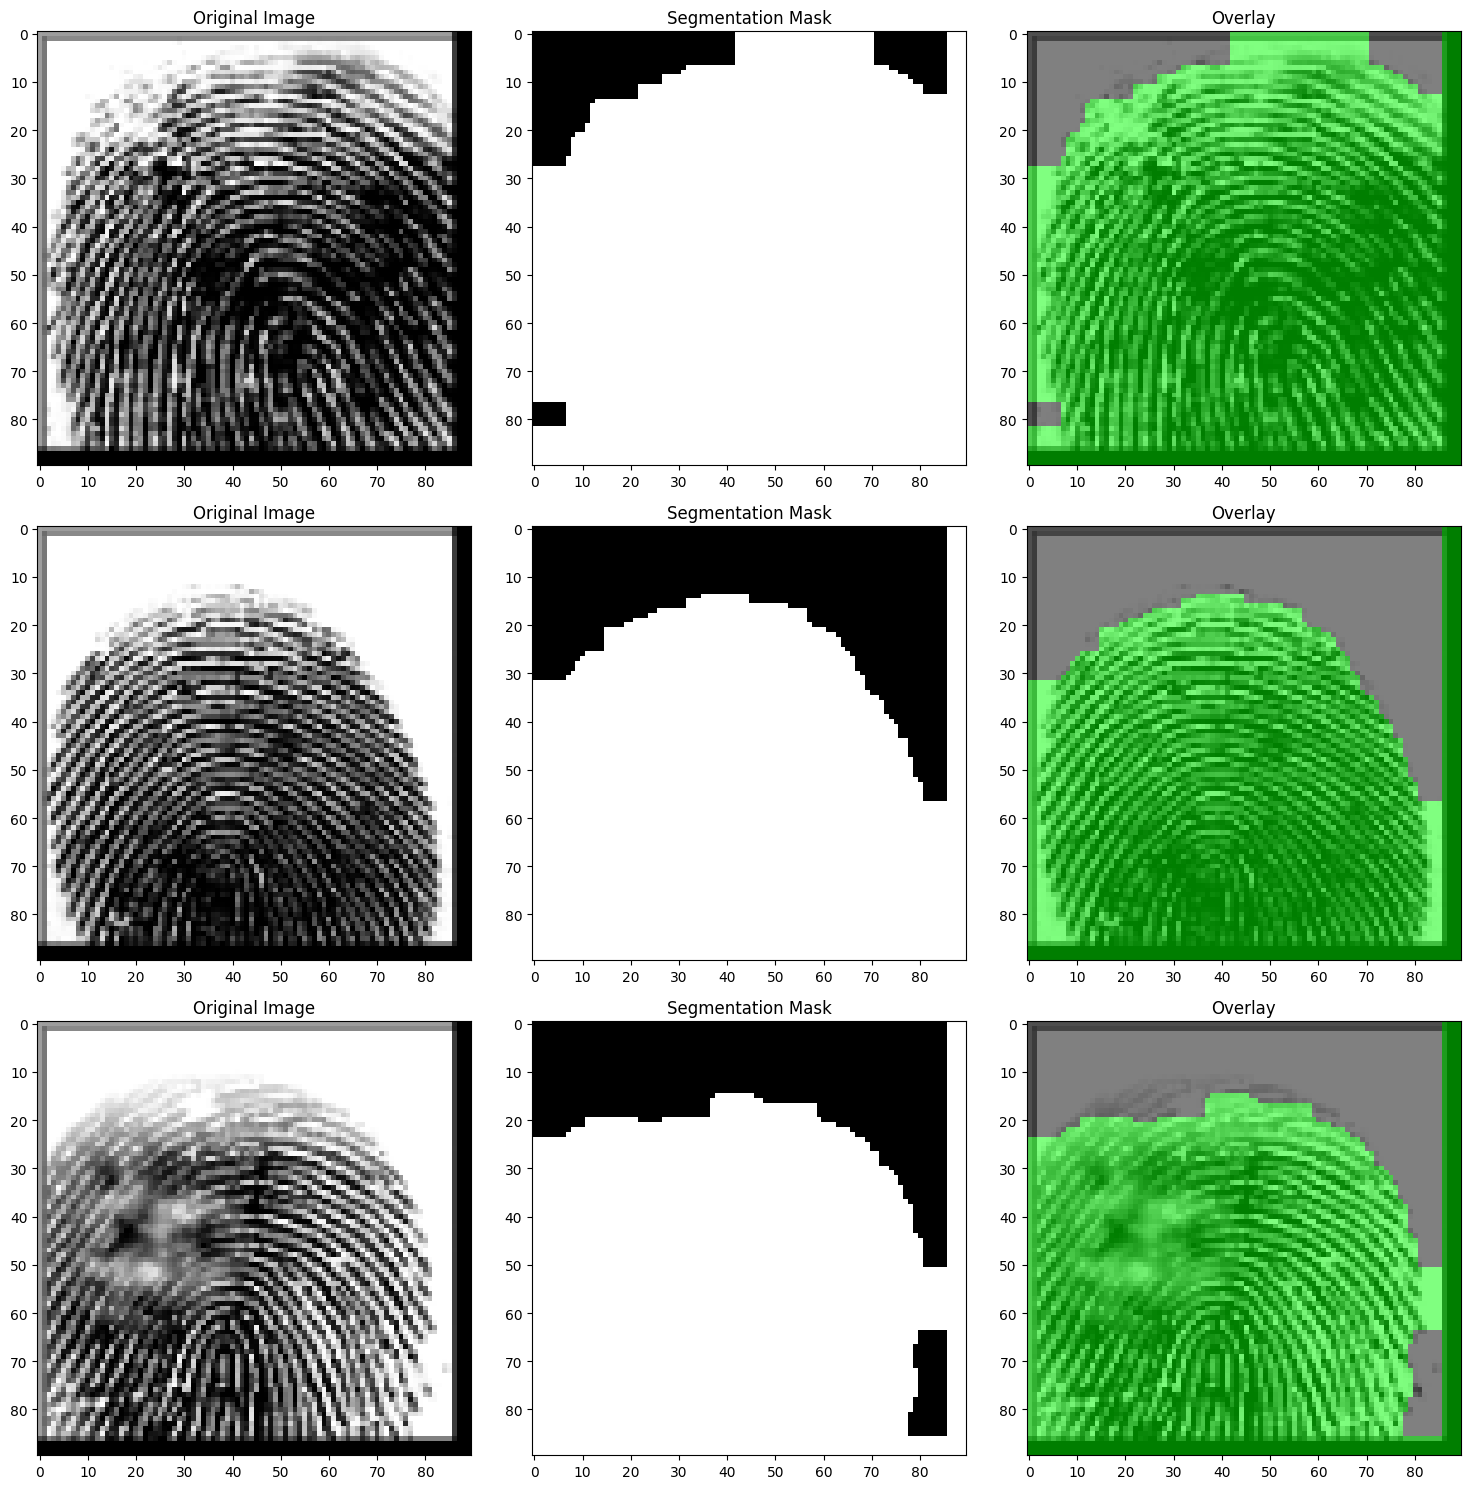

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 90, 90,    │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 90, 90,    │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 45, 45,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 45, 45,    │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 45, 45,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 22, 22,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 11, 11,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 11, 11,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 11, 11,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 22, 22,    │     32,832 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 22,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 22, 22,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 22, 22,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 44, 44,    │      8,224 │ conv2d_11[0][0] 

 Total params: 481,745 (1.84 MB)

 Trainable params: 481,745 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5


d:\fingerprint_project\fingerprint-recognition\fingerprint_backend\fingerprint_training\env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(None, 90, 90))
  warnings.warn(msg)


1382/1382 ━━━━━━━━━━━━━━━━━━━━ 327s 233ms/step - IoU: 0.9109 - loss: 0.5207 - val_IoU: 0.9494 - val_loss: 0.4556
Epoch 2/5


d:\fingerprint_project\fingerprint-recognition\fingerprint_backend\fingerprint_training\env\Lib\site-packages\keras\src\callbacks\early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_custom_iou` which is not available. Available metrics are: IoU,loss,val_IoU,val_loss
  current = self.get_monitor_value(logs)


1382/1382 ━━━━━━━━━━━━━━━━━━━━ 852s 617ms/step - IoU: 0.9498 - loss: 0.4541 - val_IoU: 0.9521 - val_loss: 0.4509
Epoch 3/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 281s 203ms/step - IoU: 0.9524 - loss: 0.4503 - val_IoU: 0.9542 - val_loss: 0.4473
Epoch 4/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 302s 218ms/step - IoU: 0.9547 - loss: 0.4462 - val_IoU: 0.9564 - val_loss: 0.4438
Epoch 5/5
1382/1382 ━━━━━━━━━━━━━━━━━━━━ 303s 220ms/step - IoU: 0.9564 - loss: 0.4434 - val_IoU: 0.9574 - val_loss: 0.4421


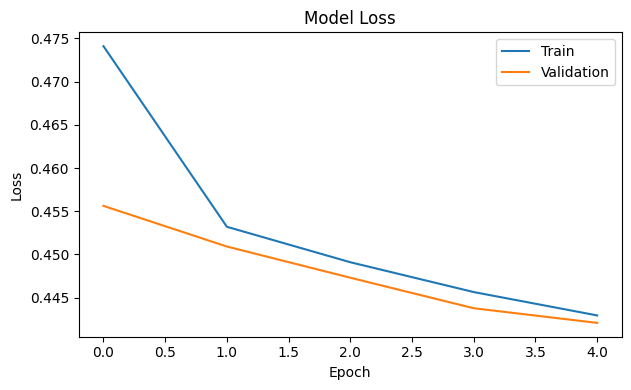

d:\fingerprint_project\fingerprint-recognition\fingerprint_backend\fingerprint_training\env\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_16']
Received: inputs=Tensor(shape=(32, 90, 90))
  warnings.warn(msg)


346/346 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step
Mean IoU on validation set: 0.9569


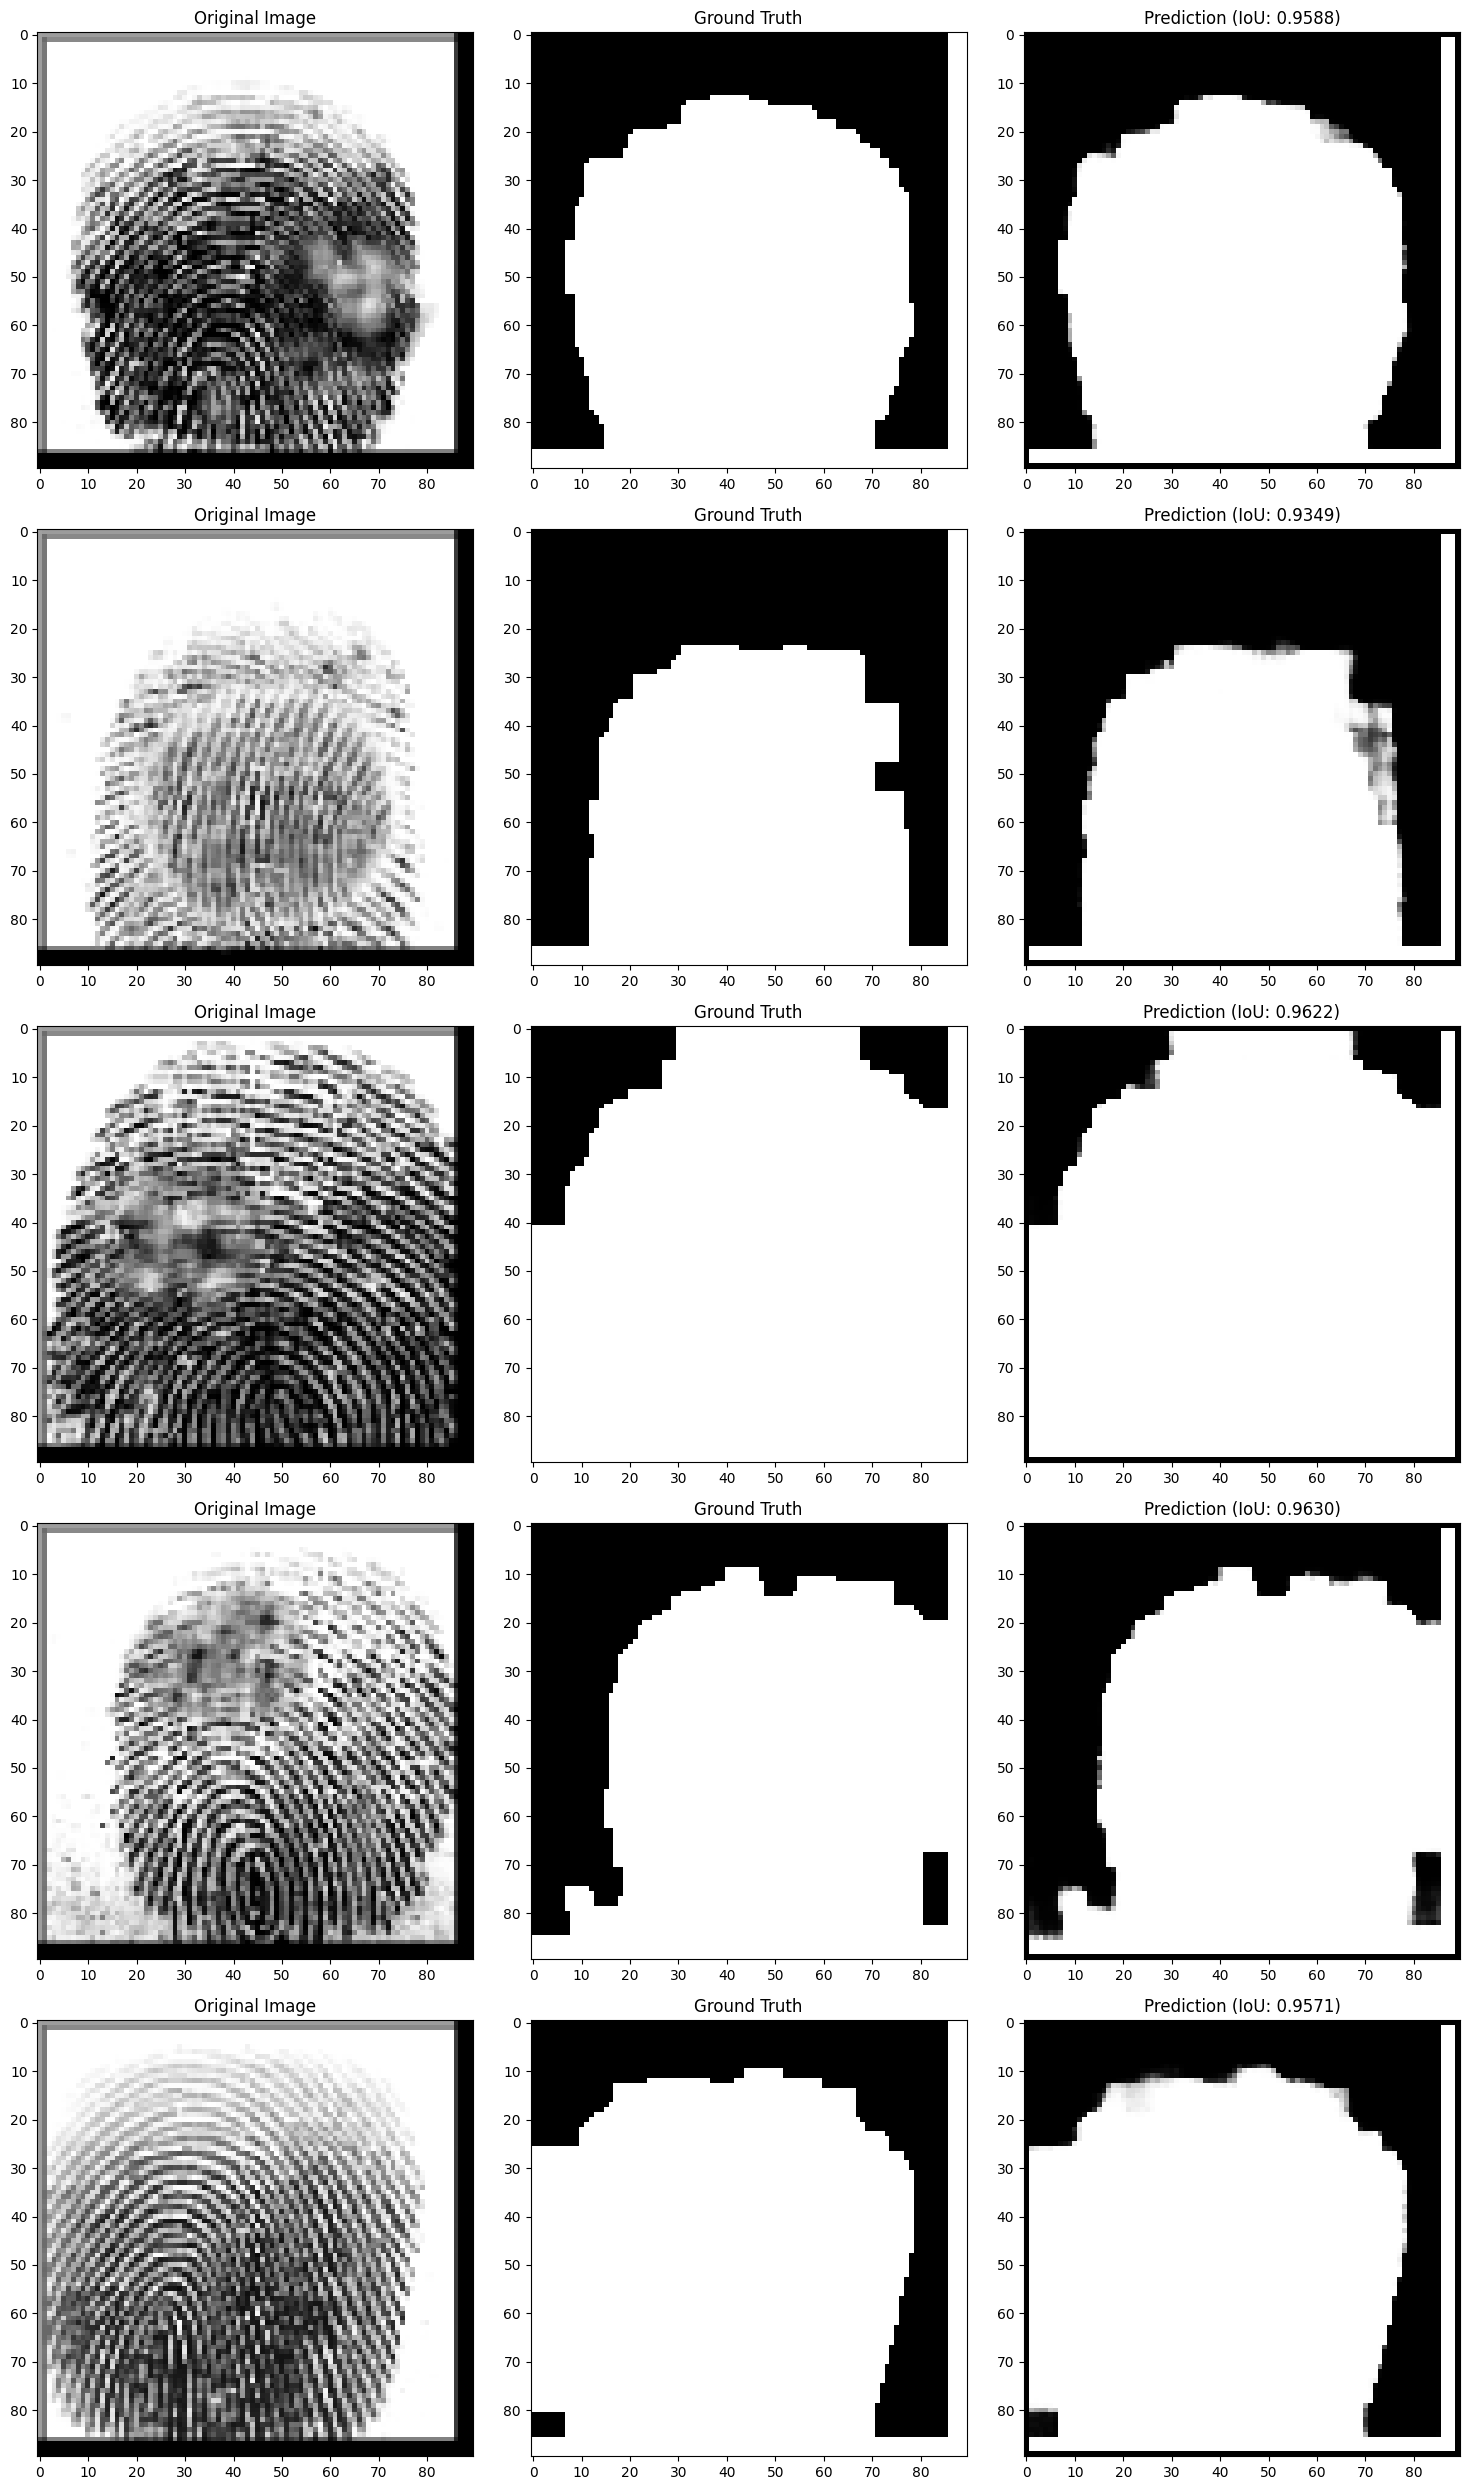

In [15]:
seg_model, seg_history = train_segmentation_model()

In [16]:
train_gen = DataGenerator(x_train, label_train, data_dict['real'][0], label_real_dict, shuffle=True)
val_gen = DataGenerator(x_val, label_val, data_dict['real'][0], label_real_dict, shuffle=False)

history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)


Epoch 1/15


d:\fingerprint_project\fingerprint-recognition\fingerprint_backend\fingerprint_training\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1385/1385 ━━━━━━━━━━━━━━━━━━━━ 140s 100ms/step - accuracy: 0.9043 - loss: 0.2189 - val_accuracy: 0.9937 - val_loss: 0.0264
Epoch 2/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 138s 100ms/step - accuracy: 0.9912 - loss: 0.0342 - val_accuracy: 0.9988 - val_loss: 0.0051
Epoch 3/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 1215s 877ms/step - accuracy: 0.9952 - loss: 0.0194 - val_accuracy: 0.9959 - val_loss: 0.0126
Epoch 4/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 112s 81ms/step - accuracy: 0.9958 - loss: 0.0160 - val_accuracy: 0.9941 - val_loss: 0.0166
Epoch 5/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 127s 92ms/step - accuracy: 0.9956 - loss: 0.0147 - val_accuracy: 0.9949 - val_loss: 0.0160
Epoch 6/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 136s 98ms/step - accuracy: 0.9968 - loss: 0.0116 - val_accuracy: 0.9967 - val_loss: 0.0108
Epoch 7/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 138s 99ms/step - accuracy: 0.9965 - loss: 0.0124 - val_accuracy: 0.9971 - val_loss: 0.0096
Epoch 8/15
1385/1385 ━━━━━━━━━━━━━━━━━━━━ 307s 222ms/step - accuracy: 0.9977

## Evaluation

This is just a test using one random image and

In [17]:
# def extract_fingerprint_region(image, seg_model, padding=10):
#     # Ensure image has proper dimensions
#     original_image = image.copy()
    
#     try:
#         # Prepare image for the segmentation model
#         if len(image.shape) == 2:
#             # Add channel dimension if grayscale
#             input_img = np.expand_dims(image, axis=-1)
#         else:
#             input_img = image
            
#         # Resize if necessary based on model's expected input shape
#         # model_input_shape = seg_model.inputs[0].shape.as_list()[1:3]  
        
#         try:
#         # Try TensorFlow tensor approach
#             model_input_shape = seg_model.inputs[0].shape.as_list()[1:3]
#         except AttributeError:
#             # Handle case where shape is a tuple
#             model_input_shape = seg_model.inputs[0].shape[1:3]
#         # Get expected height and width
#         if model_input_shape[0] is not None and model_input_shape[1] is not None:
#             # If model expects specific dimensions, resize the image
#             input_img_resized = cv2.resize(input_img, (model_input_shape[1], model_input_shape[0]))
#             # Ensure proper dimensions for model input (batch dimension)
#             input_img_resized = np.expand_dims(input_img_resized, axis=0)
#         else:
#             # If model accepts dynamic input, just add batch dimension
#             input_img_resized = np.expand_dims(input_img, axis=0)
        
#         # Predict segmentation mask
#         prediction = seg_model.predict(input_img_resized)
        
#         # Process the predicted mask
#         if len(prediction.shape) == 4:  # (batch, height, width, channels)
#             mask = prediction[0]  # Remove batch dimension
            
#             # If multi-class segmentation, take argmax or the fingerprint class
#             if mask.shape[-1] > 1:
#                 mask = np.argmax(mask, axis=-1)  # Convert to class indices
#                 # Assuming fingerprint class has index 1 (adjust if different)
#                 binary_mask = (mask == 1).astype(np.uint8) * 255
#             else:
#                 # For binary segmentation
#                 binary_mask = (mask[:, :, 0] > 0.5).astype(np.uint8) * 255
#         else:
#             # Handle unexpected output format
#             raise ValueError("Unexpected model output format")
            
#         # Resize back to original image dimensions if needed
#         if model_input_shape[0] is not None and model_input_shape[1] is not None:
#             if binary_mask.shape[:2] != image.shape[:2]:
#                 binary_mask = cv2.resize(binary_mask, (image.shape[1], image.shape[0]))
                
#     except Exception as e:
#         print(f"Segmentation model error: {e}. Using fallback thresholding method.")
#         # Fall back to the thresholding approach
#         if len(image.shape) == 2:
#             gray = image
#         else:
#             gray = image[:,:,0]
        
#         # Make sure image is in the right range for thresholding
#         if gray.max() <= 1.0:
#             gray_uint8 = (gray * 255).astype(np.uint8)
#         else:
#             gray_uint8 = gray.astype(np.uint8)
            
#         # Apply adaptive thresholding to get a binary mask
#         binary_mask = cv2.adaptiveThreshold(
#             gray_uint8, 
#             255, 
#             cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
#             cv2.THRESH_BINARY_INV, 
#             11, 
#             2
#         )
    
#     # Clean up the mask
#     kernel = np.ones((3, 3), np.uint8)
#     binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
#     binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
#     # Find contours
#     contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
#     # If no contours found, return the original image and a full-frame bounding box
#     if not contours:
#         h, w = image.shape[:2]
#         return image, (0, 0, w, h)
    
#     # Find the largest contour
#     largest_contour = max(contours, key=cv2.contourArea)
    
#     # Get bounding box of the largest contour
#     x, y, w, h = cv2.boundingRect(largest_contour)
    
#     # Add padding
#     x_min = max(0, x - padding)
#     y_min = max(0, y - padding)
#     x_max = min(original_image.shape[1], x + w + padding)
#     y_max = min(original_image.shape[0], y + h + padding)
    
#     # Crop the image
#     if len(original_image.shape) == 2:
#         cropped_image = original_image[y_min:y_max, x_min:x_max]
#     else:
#         cropped_image = original_image[y_min:y_max, x_min:x_max, :]
    
#     return cropped_image, (x_min, y_min, x_max, y_max)

def extract_fingerprint_region(image, seg_model, padding=10):
    """
    Extract the fingerprint region using the segmentation model.
    
    Args:
        image: Input fingerprint image (normalized between 0-1)
        seg_model: Trained segmentation model
        padding: Padding to add around the detected region
        
    Returns:
        cropped_image: Cropped fingerprint region
        bbox: Bounding box coordinates (x_min, y_min, x_max, y_max)
    """
    # Ensure image has proper dimensions
    original_image = image.copy()
    
    try:
        # Prepare image for the segmentation model
        if len(image.shape) == 2:
            # Add channel dimension if grayscale
            input_img = np.expand_dims(image, axis=-1)
        else:
            input_img = image
            
        # Resize if necessary based on model's expected input shape
        # model_input_shape = seg_model.inputs[0].shape.as_list()[1:3]  
        
        try:
        # Try TensorFlow tensor approach
            model_input_shape = seg_model.inputs[0].shape.as_list()[1:3]
        except AttributeError:
            # Handle case where shape is a tuple
            model_input_shape = seg_model.inputs[0].shape[1:3]
        # Get expected height and width
        if model_input_shape[0] is not None and model_input_shape[1] is not None:
            # If model expects specific dimensions, resize the image
            input_img_resized = cv2.resize(input_img, (model_input_shape[1], model_input_shape[0]))
            # Ensure proper dimensions for model input (batch dimension)
            input_img_resized = np.expand_dims(input_img_resized, axis=0)
        else:
            # If model accepts dynamic input, just add batch dimension
            input_img_resized = np.expand_dims(input_img, axis=0)
        
        # Predict segmentation mask
        prediction = seg_model.predict(input_img_resized)
        
        # Process the predicted mask
        if len(prediction.shape) == 4:  # (batch, height, width, channels)
            mask = prediction[0]  # Remove batch dimension
            
            # If multi-class segmentation, take argmax or the fingerprint class
            if mask.shape[-1] > 1:
                mask = np.argmax(mask, axis=-1)  # Convert to class indices
                # Assuming fingerprint class has index 1 (adjust if different)
                binary_mask = (mask == 1).astype(np.uint8) * 255
            else:
                # For binary segmentation
                binary_mask = (mask[:, :, 0] > 0.5).astype(np.uint8) * 255
        else:
            # Handle unexpected output format
            raise ValueError("Unexpected model output format")
            
        # Resize back to original image dimensions if needed
        if model_input_shape[0] is not None and model_input_shape[1] is not None:
            if binary_mask.shape[:2] != image.shape[:2]:
                binary_mask = cv2.resize(binary_mask, (image.shape[1], image.shape[0]))
                
    except Exception as e:
        print(f"Segmentation model error: {e}. Using fallback thresholding method.")
        # Fall back to the thresholding approach
        if len(image.shape) == 2:
            gray = image
        else:
            gray = image[:,:,0]
        
        # Make sure image is in the right range for thresholding
        if gray.max() <= 1.0:
            gray_uint8 = (gray * 255).astype(np.uint8)
        else:
            gray_uint8 = gray.astype(np.uint8)
            
        # Apply adaptive thresholding to get a binary mask
        binary_mask = cv2.adaptiveThreshold(
            gray_uint8, 
            255, 
            cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 
            11, 
            2
        )
    
    # Clean up the mask
    kernel = np.ones((3, 3), np.uint8)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    binary_mask = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    
    # Find contours
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # If no contours found, return the original image and a full-frame bounding box
    if not contours:
        h, w = image.shape[:2]
        return image, (0, 0, w, h)
    
    # Find the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    
    # Get bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Add padding
    x_min = max(0, x - padding)
    y_min = max(0, y - padding)
    x_max = min(original_image.shape[1], x + w + padding)
    y_max = min(original_image.shape[0], y + h + padding)
    
    # Crop the image
    if len(original_image.shape) == 2:
        cropped_image = original_image[y_min:y_max, x_min:x_max]
    else:
        cropped_image = original_image[y_min:y_max, x_min:x_max, :]
    
    return cropped_image, (x_min, y_min, x_max, y_max)

In [18]:
def visualize_extracted_regions(images, seg_model=None, num_samples=5):
    """
    Visualize the extracted fingerprint regions.
    
    Args:
        images: Array of fingerprint images
        seg_model: Not used in this version, kept for compatibility
        num_samples: Number of random samples to visualize
    """
    # Convert to numpy array if not already
    if not isinstance(images, np.ndarray):
        images = np.array(images)
    
    # Select random samples
    if len(images) <= num_samples:
        indices = list(range(len(images)))
    else:
        indices = np.random.choice(range(len(images)), num_samples, replace=False)
    
    plt.figure(figsize=(15, 5*len(indices)))
    for i, idx in enumerate(indices):
        # Get original image
        image = images[idx].copy()  # Make a copy to avoid modifying original
        
        # Handle different input formats
        if len(image.shape) == 3 and (image.shape[0] == 1 or image.shape[-1] == 1):
            image = image.squeeze()  # Remove singleton dimensions
        
        # Normalize if needed
        if image.max() > 1.0:
            image = image / 255.0
        
        try:
            print(f"Processing image {idx}, shape: {image.shape}")
            # Extract region using classical CV methods
            cropped, bbox = extract_fingerprint_region(image, seg_model)
            
            # Original image
            plt.subplot(len(indices), 3, i*3+1)
            plt.title('Original Image')
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            
            # Draw bounding box on original
            plt.subplot(len(indices), 3, i*3+2)
            plt.title('Detected Region')
            plt.imshow(image, cmap='gray')
            x_min, y_min, x_max, y_max = bbox
            rect = plt.Rectangle((x_min, y_min), x_max-x_min, y_max-y_min, 
                              fill=False, edgecolor='red', linewidth=2)
            plt.gca().add_patch(rect)
            plt.axis('off')
            
            # Cropped and resized image
            plt.subplot(len(indices), 3, i*3+3)
            plt.title('Cropped Region')
            plt.imshow(cropped, cmap='gray')
            plt.axis('off')
            
        except Exception as e:
            print(f"Error processing image {idx}: {e}")
            plt.subplot(len(indices), 3, i*3+1)
            plt.title(f'Error: {str(e)[:20]}...')
            plt.imshow(image, cmap='gray')
            plt.axis('off')
            
            # Leave other plots empty
            plt.subplot(len(indices), 3, i*3+2)
            plt.title('Error occurred')
            plt.axis('off')
            
            plt.subplot(len(indices), 3, i*3+3)
            plt.axis('off')
            
    plt.tight_layout()
    plt.show()

Processing image 27352, shape: (90, 90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Processing image 807, shape: (90, 90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Processing image 21968, shape: (90, 90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Processing image 18465, shape: (90, 90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Processing image 30541, shape: (90, 90)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


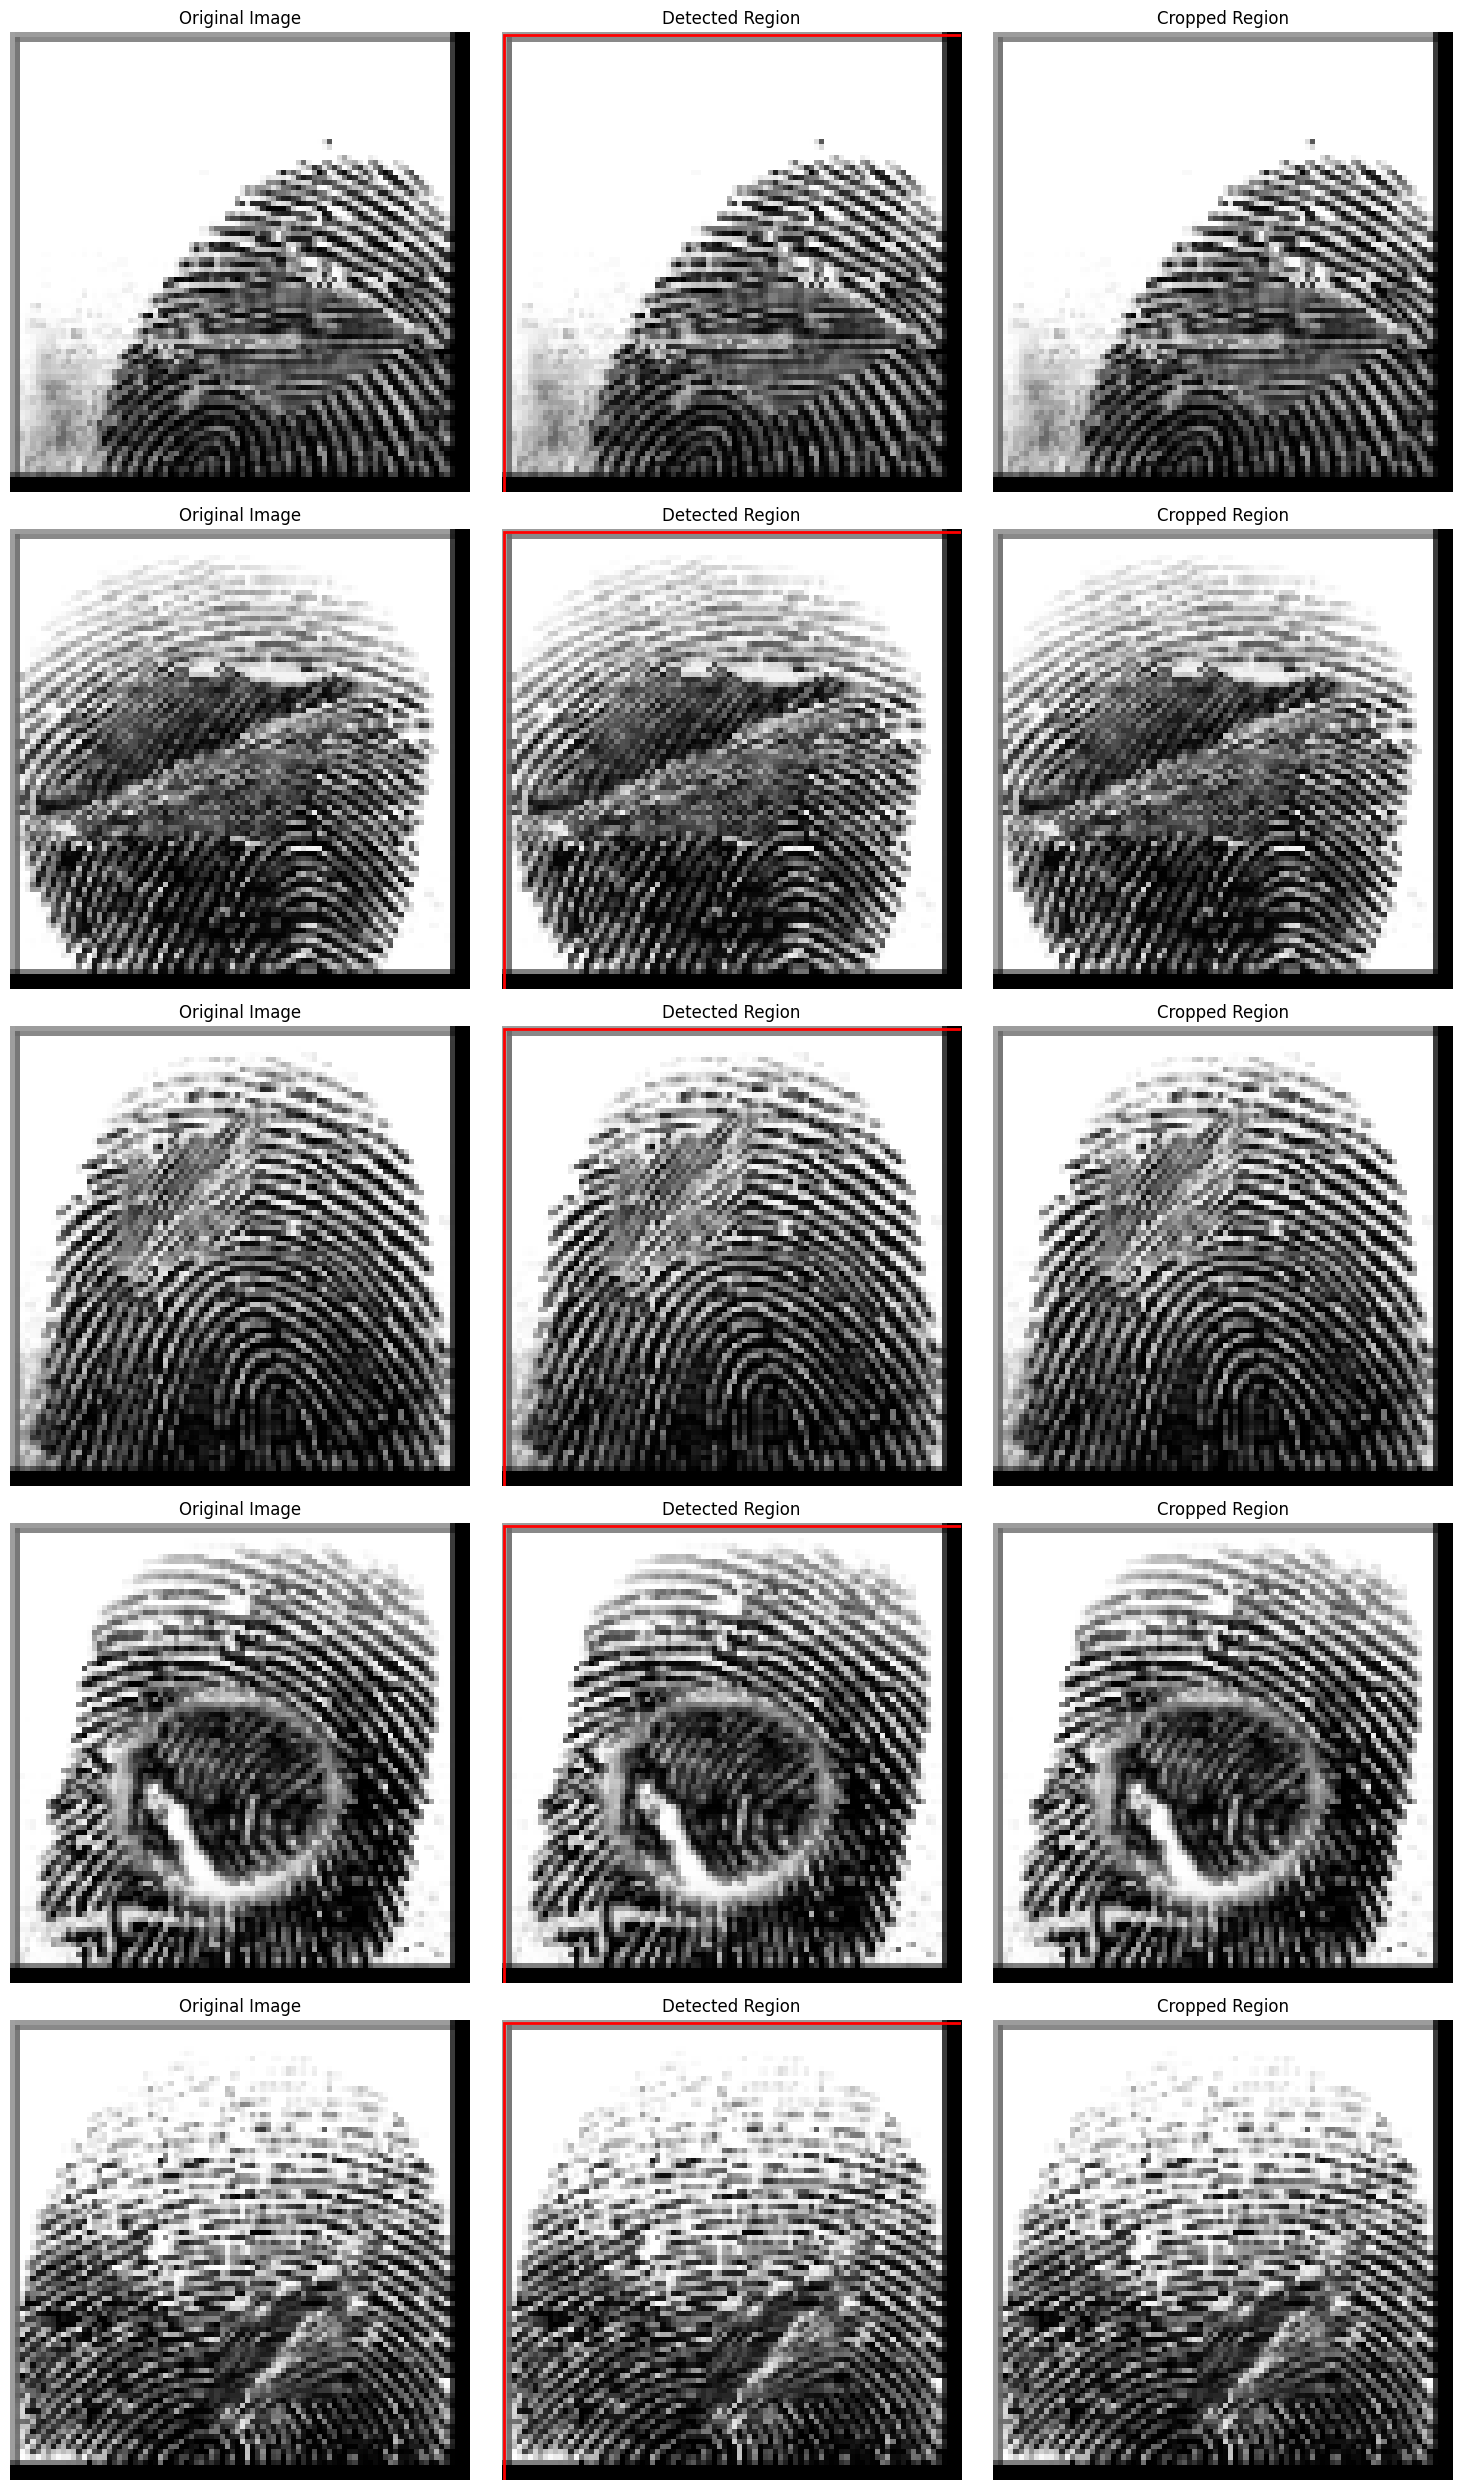

In [19]:
visualize_extracted_regions(x_train, seg_model)

In [20]:
def evaluate_combined_pipeline(fingerprint_model, seg_model, x_val, label_val, data_dict, label_real_dict, num_samples=1):
    """
    Evaluate the complete fingerprint matching pipeline with region detection.
    """
    results = []
    
    # indices = np.random.choice(range(len(x_val)), num_samples, replace=False)
    num_samples = min(num_samples, len(x_val))
    indices = np.random.choice(range(len(x_val)), num_samples, replace=False)
    
    valid_size = len(x_val)
    num_samples = min(num_samples, valid_size) 
    indices = np.random.choice(valid_size, num_samples, replace=False)
    
    plt.figure(figsize=(20, 5*num_samples))
    for i, idx in enumerate(indices):
        input_img = x_val[idx].copy()
        match_key = ''.join(label_val[idx].astype(str)).zfill(6)
        
        # Get matching real fingerprint
        matched_img = data_dict['real'][0][label_real_dict[match_key]].copy()
        
        # Get random non-matching fingerprint
        while True:
            unmatch_key, unmatch_idx = random.choice(list(label_real_dict.items()))
            if unmatch_key != match_key:
                unmatched_img = data_dict['real'][0][unmatch_idx].copy()
                break
        
        # Process input image
        input_normalized = input_img.astype(np.float32) / 255.0
        input_segmented, input_bbox = extract_fingerprint_region(input_normalized, seg_model)
        input_segmented = input_segmented.reshape(1, 90, 90, 1)
        
        # Process matched image
        matched_normalized = matched_img.astype(np.float32) / 255.0
        matched_segmented, matched_bbox = extract_fingerprint_region(matched_normalized, seg_model)
        matched_segmented = matched_segmented.reshape(1, 90, 90, 1)
        
        # Process unmatched image
        unmatched_normalized = unmatched_img.astype(np.float32) / 255.0
        unmatched_segmented, unmatched_bbox = extract_fingerprint_region(unmatched_normalized, seg_model)
        unmatched_segmented = unmatched_segmented.reshape(1, 90, 90, 1)
        
        # Predict similarity
        pred_matched = fingerprint_model.predict([input_segmented, matched_segmented])[0][0]
        pred_unmatched = fingerprint_model.predict([input_segmented, unmatched_segmented])[0][0]
        
        results.append({
            'input_id': idx,
            'match_score': pred_matched,
            'unmatch_score': pred_unmatched,
            'correct': pred_matched > 0.5 and pred_unmatched < 0.5
        })
        
        # Original images with bounding boxes
        plt.subplot(num_samples, 6, i*6+1)
        plt.title(f'Input: {label_val[idx]}')
        plt.imshow(input_img.squeeze(), cmap='gray')
        rect = plt.Rectangle((input_bbox[0], input_bbox[1]), 
                           input_bbox[2]-input_bbox[0], input_bbox[3]-input_bbox[1], 
                           fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        
        plt.subplot(num_samples, 6, i*6+2)
        plt.title('Input Segmented')
        plt.imshow(input_segmented.squeeze(), cmap='gray')
        
        # Matched pair
        plt.subplot(num_samples, 6, i*6+3)
        plt.title(f'Match')
        plt.imshow(matched_img.squeeze(), cmap='gray')
        rect = plt.Rectangle((matched_bbox[0], matched_bbox[1]), 
                           matched_bbox[2]-matched_bbox[0], matched_bbox[3]-matched_bbox[1], 
                           fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        
        plt.subplot(num_samples, 6, i*6+4)
        plt.title(f'Match Segmented\nScore: {pred_matched:.2f}')
        plt.imshow(matched_segmented.squeeze(), cmap='gray')
        
        # Unmatched pair
        plt.subplot(num_samples, 6, i*6+5)
        plt.title(f'Unmatch')
        plt.imshow(unmatched_img.squeeze(), cmap='gray')
        rect = plt.Rectangle((unmatched_bbox[0], unmatched_bbox[1]), 
                           unmatched_bbox[2]-unmatched_bbox[0], unmatched_bbox[3]-unmatched_bbox[1], 
                           fill=False, edgecolor='red', linewidth=2)
        plt.gca().add_patch(rect)
        
        plt.subplot(num_samples, 6, i*6+6)
        plt.title(f'Unmatch Segmented\nScore: {pred_unmatched:.2f}')
        plt.imshow(unmatched_segmented.squeeze(), cmap='gray')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate accuracy
    correct_predictions = sum(1 for r in results if r['correct'])
    accuracy = correct_predictions / len(results)
    print(f"Pipeline accuracy on sample: {accuracy:.2f}")
    
    return results

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


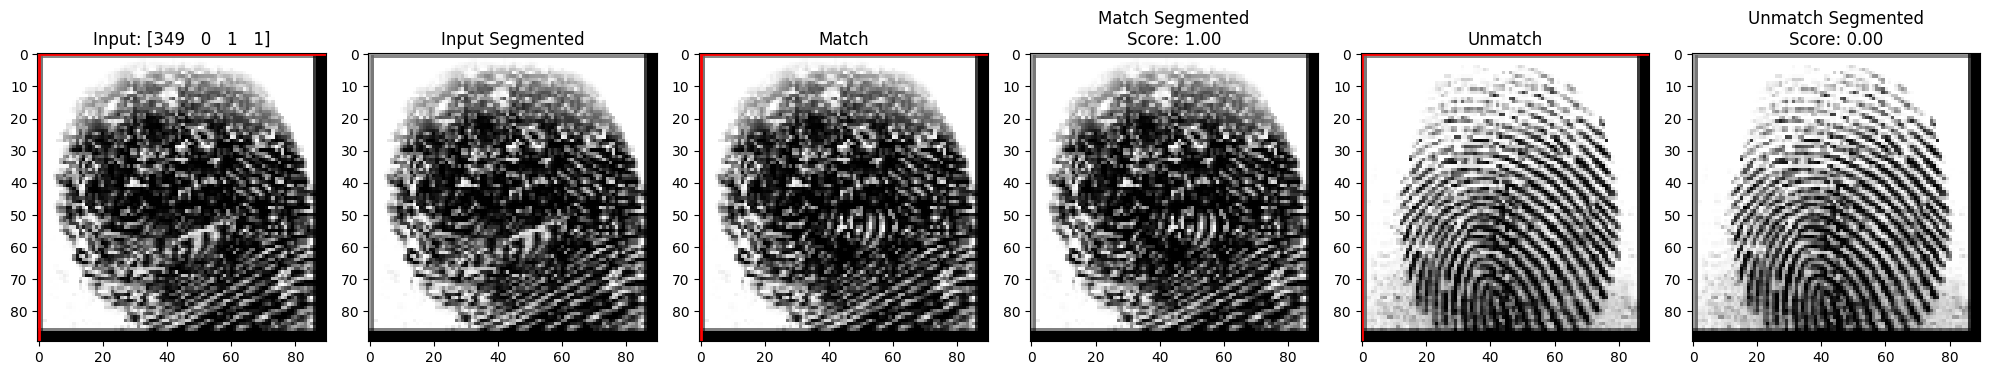

Pipeline accuracy on sample: 1.00


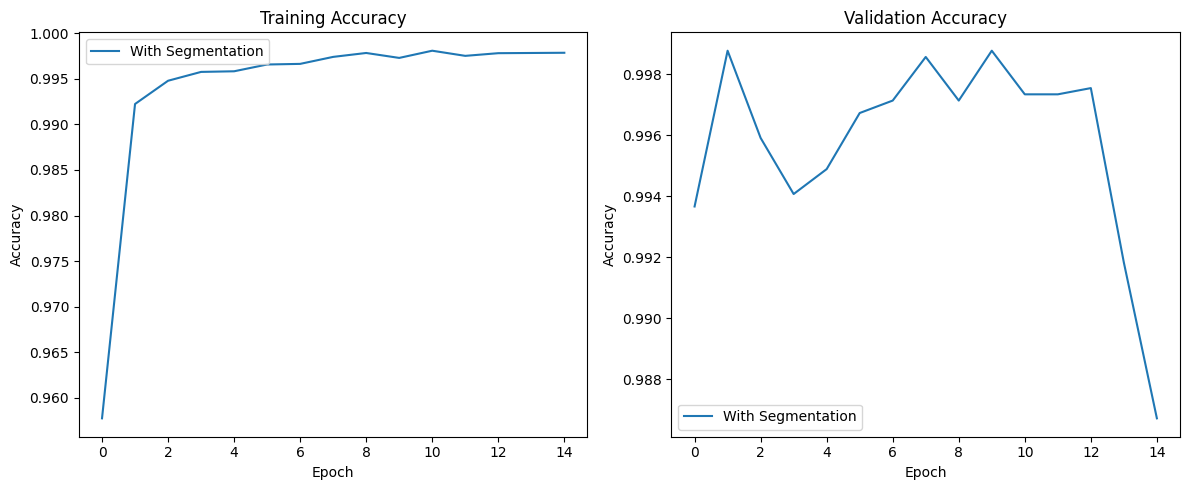

In [21]:
evaluate_combined_pipeline(model, seg_model, x_val, label_val, data_dict, label_real_dict)

# Compare performance between original and enhanced models
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
# plt.plot(history.history['accuracy'], label='Original')
plt.plot(history.history['accuracy'], label='With Segmentation') 
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_accuracy'], label='With Segmentation')  
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Store Models

In [39]:
import os
import json
import time
from datetime import datetime
import numpy as np
from tensorflow.keras.models import load_model, save_model
import tensorflow as tf

def create_folder_structure():
    """Create the necessary folder structure for storing models"""
    os.makedirs('../fingerprint_models', exist_ok=True)
    os.makedirs('../reports', exist_ok=True)
    os.makedirs('../fingerprint_models/recognition', exist_ok=True)
    os.makedirs('../fingerprint_models/segmentation', exist_ok=True)
    print("Folder structure created successfully.")

def store_model(model, model_type, model_name, version=None, accuracy=None, val_accuracy=None):
    if model_type not in ['recognition', 'segmentation']:
        raise ValueError("model_type must be either 'recognition' or 'segmentation'")

    model_id = f"{model_name.replace(' ', '_').lower()}"
    
    folder_path = f"../fingerprint_models/{model_type}"
    path_name = f"{'_'.join([x.lower() for x in model_name.split()])}"
    model_path = f"{folder_path}/{path_name}.keras"  
    save_model(model, model_path) 
    print(f"Model saved to {model_path}")
    
    now = datetime.now().isoformat()
    _history = model.history.history
    metadata = {
        "name": model_name,
        "path_name": path_name,
        "accuracy": accuracy, 
        "valAccuracy": val_accuracy, 
        "createdAt": now,
        "updatedAt": now,
        "version": version
    }
    
    if version is not None:
        metadata["version"] = version
    
    return metadata


def update_model_list(model_type, model_metadata):
    if model_type not in ['recognition', 'segmentation']:
        raise ValueError("model_type must be either 'recognition' or 'segmentation'")
    
    json_path = f"../reports/fingerprint_{model_type}_models.json"
    
    # Check if the file exists and is not empty
    if os.path.exists(json_path) and os.path.getsize(json_path) > 0:
        with open(json_path, 'r') as f:
            try:
                models = json.load(f)
            except json.JSONDecodeError:
                print(f"Warning: Corrupt JSON file detected at {json_path}. Resetting file.")
                models = []  # Reset to empty list if corruption occurs
    else:
        models = []
    
    # Add new model metadata
    models.append(model_metadata)
    
    # Save the updated list
    with open(json_path, 'w') as f:
        json.dump(models, f, indent=4)  # Fixed incorrect json.dumps usage
    
    print(f"Updated {json_path} with new model information")

# def calculate_accuracy(model, test_generator, num_batches=None):
#     results = model.evaluate(test_generator, steps=num_batches)
#     return results[1]  # Assuming accuracy is the second metric

# def calculate_iou_accuracy(seg_model, x_val, y_val):
#     y_pred = seg_model.predict(x_val)
    
#     iou_scores = []
#     for i in range(len(y_val)):
#         true = y_val[i].squeeze()
#         pred = (y_pred[i].squeeze() > 0.5).astype(np.float32)
        
#         intersection = np.sum(true * pred)
#         union = np.sum(true) + np.sum(pred) - intersection
#         iou = intersection / (union + 1e-7)
#         iou_scores.append(iou)
    
#     mean_iou = np.mean(iou_scores)
#     return mean_iou

# create_folder_structure()
# x_images, y_masks = load_segmentation_dataset()
# x_images = x_images.astype(np.float32) / 255.0

# x_train, x_val, y_train, y_val = train_test_split(
#     x_images, y_masks, test_size=0.2, random_state=42
# )

# iou_accuracy = calculate_iou_accuracy(seg_model, x_val, y_val)
# recognition_accuracy = calculate_accuracy(model, val_gen)

seg_metadata = store_model(
    seg_model,
    model_type='segmentation',
    model_name='UNet Segmentation v1_0',
    version='1.0',
    accuracy=float(np.mean(history.history['accuracy'])),
    val_accuracy=float(np.mean(history.history['val_accuracy']))
)

update_model_list('segmentation', seg_metadata)


rec_metadata = store_model(
    model=model,
    model_type='recognition',
    model_name='Siamese Network v1_0',
    version='1.0',
    accuracy=float(np.mean(seg_history.history['IoU'])),
    val_accuracy=float(np.mean(seg_history.history['val_IoU']))
)
    
update_model_list('recognition', rec_metadata)

Model saved to ../fingerprint_models/segmentation/unet_segmentation_v1_0.keras
Updated ../reports/fingerprint_segmentation_models.json with new model information
Model saved to ../fingerprint_models/recognition/siamese_network_v1_0.keras
Updated ../reports/fingerprint_recognition_models.json with new model information


In [34]:
import json
from datetime import datetime

def generate_training_data_json():
    training_data = {
        "name": "SOCOFing-Training",
        "purpose": "recognition and segmentation", 
        "sampleCount": 6000,
        "createdAt": datetime.now().isoformat(),
        "updatedAt": datetime.now().isoformat(),
        "source": "https://www.kaggle.com/datasets/ruizgara/socofing",
        "resolution": "256x256",
        "format": "TIFF",
    }

    json_path = "../reports/training_data_info.json"
    
    with open(json_path, 'w') as f:
        json.dump([training_data], f, indent=4)

    print(f"Training data information saved to {json_path}")

if __name__ == "__main__":
    generate_training_data_json()


Training data information saved to ../reports/training_data.json


In [ ]:
# model.summary()
print("Siamense accuracy avg training:", np.mean(history.history['accuracy']))


In [29]:
seg_model.summary()
print("Unet avg training:", np.mean(seg_history.history['IoU']))
print("Unet avg training:", np.mean(seg_history.history['val_IoU']))


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 90, 90, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 90, 90,    │        160 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 90, 90,    │      2,320 │ conv2d_2[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 45, 45,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 45, 45,    │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 45, 45,    │      9,248 │ conv2d_4[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 22, 22,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 22, 22,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 22, 22,    │     36,928 │ conv2d_6[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 11, 11,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 11, 11,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 11, 11,    │    147,584 │ conv2d_8[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 22, 22,    │     32,832 │ conv2d_9[0][0]    │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 22, 22,    │          0 │ conv2d_transpose… │
│ (Concatenate)       │ 128)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 22, 22,    │     73,792 │ concatenate[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 22, 22,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 44, 44,    │      8,224 │ conv2d_11[0][0] 

 Total params: 1,445,237 (5.51 MB)

 Trainable params: 481,745 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 963,492 (3.68 MB)

Unet avg training: 0.9507028937339783
Unet avg training: 0.9539023041725159
